# EE 467 Lab 2 (PyTorch): Breaking CAPTCHAs with Deep Learning

This notebook is a PyTorch rewrite of the original TensorFlow/Keras lab notebook.

**Pipeline**
1. Extract `captcha-images` dataset  
2. Load & preprocess CAPTCHA images (grayscale + padding)  
3. Split into train/val (TV) vs test CAPTCHAs  
4. Extract 4 characters per CAPTCHA via contours and save per-class character images  
5. Train a CNN to classify single characters  
6. Evaluate the full CAPTCHA pipeline end-to-end on the held-out test set


In [1]:
# If needed (e.g., Colab), install dependencies:
# %pip install matplotlib scikit-learn "opencv-python>4" imutils torch torchvision

import os, glob, math, tarfile, pickle
from pprint import pprint

import cv2
import numpy as np
from imutils import paths

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

from helpers import resize_to_fit, unzip, group_every, print_images


In [2]:
# -----------------------------
# Dataset extraction
# -----------------------------
CAPTCHA_TAR_PATH = "./captcha-images.tar.xz"
CAPTCHA_IMAGE_FOLDER = "./captcha-images"

def maybe_extract_dataset(tar_path: str, out_dir: str) -> None:
    if os.path.exists(out_dir) and len(glob.glob(os.path.join(out_dir, "*.png"))) > 0:
        return
    with tarfile.open(tar_path, mode="r:xz") as tf:
        tf.extractall(path=os.path.dirname(out_dir) or ".")

maybe_extract_dataset(CAPTCHA_TAR_PATH, CAPTCHA_IMAGE_FOLDER)

captcha_image_paths = list(paths.list_images(CAPTCHA_IMAGE_FOLDER))
pprint(captcha_image_paths[:10])
print("Total CAPTCHAs:", len(captcha_image_paths))


/tmp/ipython-input-3652207630.py:11: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tf.extractall(path=os.path.dirname(out_dir) or ".")


['./captcha-images/J3NJ.png',
 './captcha-images/2QRH.png',
 './captcha-images/E7ZC.png',
 './captcha-images/2GHE.png',
 './captcha-images/L4M9.png',
 './captcha-images/M4YZ.png',
 './captcha-images/M4PD.png',
 './captcha-images/8CRP.png',
 './captcha-images/C4NZ.png',
 './captcha-images/M4BT.png']
Total CAPTCHAs: 1136


In [3]:
# -----------------------------
# Ground truth extraction from filenames
# -----------------------------
def extract_captcha_text(image_path: str) -> str:
    image_file_name = os.path.basename(image_path)
    return os.path.splitext(image_file_name)[0]

captcha_texts = [extract_captcha_text(p) for p in captcha_image_paths]
pprint(captcha_texts[:10])


['J3NJ', '2QRH', 'E7ZC', '2GHE', 'L4M9', 'M4YZ', 'M4PD', '8CRP', 'C4NZ', 'M4BT']


## Loading and transforming images

We load each CAPTCHA, convert it to grayscale, and add 8px padding around it.


Figure(2000x500)


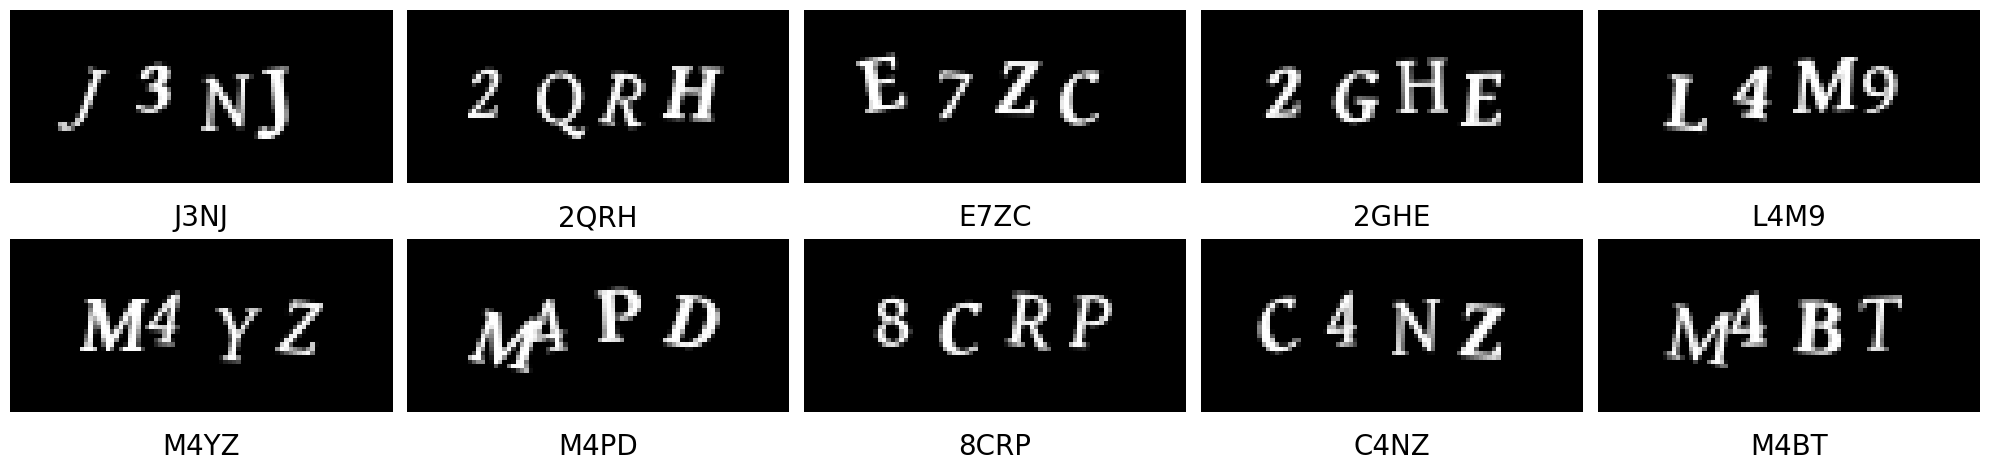

In [4]:
def load_transform_image(image_path: str) -> np.ndarray:
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Failed to load image: {image_path}")
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_padded = cv2.copyMakeBorder(
        image_gray, 8, 8, 8, 8, borderType=cv2.BORDER_REPLICATE
    )
    return image_padded

captcha_images = [load_transform_image(p) for p in captcha_image_paths]

print_images(captcha_images[:10], n_rows=2, texts=captcha_texts[:10])


In [5]:
# -----------------------------
# Train/val-test split
# -----------------------------
TVT_SPLIT_SEED = 31528476

captcha_images_tv, captcha_images_test, captcha_texts_tv, captcha_texts_test = train_test_split(
    captcha_images, captcha_texts, test_size=0.2, random_state=TVT_SPLIT_SEED
)

print("Train-validation:", len(captcha_texts_tv))
print("Test:", len(captcha_texts_test))


Train-validation: 908
Test: 228


## Bounding box extraction (character crops)

We find contours in the thresholded image, convert them into bounding boxes, split overly-wide boxes, and keep only CAPTCHAs that produce exactly 4 character regions.


In [6]:
CHAR_IMAGE_FOLDER = f"./char-images-{TVT_SPLIT_SEED}"

def extract_chars(image_gray_padded: np.ndarray):
    image_bw = cv2.threshold(
        image_gray_padded, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU
    )[1]
    contours = cv2.findContours(image_bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]

    char_regions = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w / h > 1.25:
            half = int(w / 2)
            char_regions.append((x, y, half, h))
            char_regions.append((x + half, y, half, h))
        else:
            char_regions.append((x, y, w, h))

    if len(char_regions) != 4:
        return None

    char_regions.sort(key=lambda t: t[0])
    char_images = []
    for x, y, w, h in char_regions:
        char_images.append(image_gray_padded[y-2:y+h+2, x-2:x+w+2])
    return char_images

def save_chars(char_images, captcha_text, save_dir, char_counts):
    for char_image, char in zip(char_images, captcha_text):
        save_path = os.path.join(save_dir, char)
        os.makedirs(save_path, exist_ok=True)
        cnt = char_counts.get(char, 1)
        out_path = os.path.join(save_path, f"{cnt}.png")
        cv2.imwrite(out_path, char_image)
        char_counts[char] = cnt + 1

FORCE_EXTRACT_CHAR = False

char_counts = {}
if FORCE_EXTRACT_CHAR or not os.path.exists(CHAR_IMAGE_FOLDER):
    for captcha_image, captcha_text in zip(captcha_images_tv, captcha_texts_tv):
        chars = extract_chars(captcha_image)
        if chars is None:
            continue
        save_chars(chars, captcha_text, CHAR_IMAGE_FOLDER, char_counts)

print("Char folder:", CHAR_IMAGE_FOLDER)


Char folder: ./char-images-31528476


## Label encoding + features

We resize each character crop to **20×20**, add a channel dimension (1), and scale pixel values into **[0, 1]**.

In PyTorch we train with `CrossEntropyLoss`, so labels are **integer class indices** (not one-hot vectors).


In [7]:
LABELS_PATH = "./labels_pytorch.pkl"

def make_feature(image_gray: np.ndarray) -> np.ndarray:
    image_resized = resize_to_fit(image_gray, 20, 20)
    return image_resized[..., None]  # (20,20,1)

def make_feature_label(image_path: str):
    image_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image_gray is None:
        raise FileNotFoundError(f"Failed to load char image: {image_path}")
    feature = make_feature(image_gray)
    label = image_path.split(os.path.sep)[-2]
    return feature, label

features_tv, labels_tv = unzip((
    make_feature_label(p) for p in paths.list_images(CHAR_IMAGE_FOLDER)
))

X = np.array(features_tv, dtype=np.float32) / 255.0

classes = sorted(list(set(labels_tv)))
char_to_idx = {c: i for i, c in enumerate(classes)}
idx_to_char = {i: c for c, i in char_to_idx.items()}
y = np.array([char_to_idx[l] for l in labels_tv], dtype=np.int64)

n_classes = len(classes)
print("n_classes:", n_classes)

# train/val split of single-character dataset
CHAR_SPLIT_SEED = 955996
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=CHAR_SPLIT_SEED)

with open(LABELS_PATH, "wb") as f:
    pickle.dump({"classes": classes, "char_to_idx": char_to_idx, "idx_to_char": idx_to_char}, f)

print("Saved label mapping ->", LABELS_PATH)


n_classes: 32
Saved label mapping -> ./labels_pytorch.pkl


## PyTorch Dataset + DataLoaders

We convert **(20,20,1)** to channel-first **(1,20,20)** tensors.


In [8]:
class NumpyCharDataset(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray):
        self.X = X
        self.y = y

    def __len__(self):
        return int(self.X.shape[0])

    def __getitem__(self, idx: int):
        x = self.X[idx]  # (20,20,1)
        x_t = torch.from_numpy(np.transpose(x, (2, 0, 1))).float()  # (1,20,20)
        y_t = torch.tensor(self.y[idx]).long()
        return x_t, y_t

BATCH_SIZE = 32
train_loader = DataLoader(NumpyCharDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader   = DataLoader(NumpyCharDataset(X_val, y_val),   batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

next(iter(train_loader))[0].shape, next(iter(train_loader))[1].shape


(torch.Size([32, 1, 20, 20]), torch.Size([32]))

## CNN model (matches the sample snippet shapes)

Input: (20,20,1)  
Conv1: 8 filters, 5×5, stride 1, same padding → (20,20,8)  
Pool1: 2×2, stride 2 → (10,10,8)  
Conv2: 16 filters, 5×5, stride 1, same padding → (10,10,16)  
Pool2: 2×2, stride 2 → (5,5,16)  
Flatten → 400  
Dense → 64  
Output → n_classes


In [9]:
class CaptchaCNN(nn.Module):
    def __init__(self, n_classes: int):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(8, 16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16 * 5 * 5, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, n_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CaptchaCNN(n_classes=n_classes).to(device)
model


CaptchaCNN(
  (features): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=400, out_features=64, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=64, out_features=32, bias=True)
  )
)

## Training loop

We train with:
- `CrossEntropyLoss` (expects integer labels)
- `Adam` optimizer


In [10]:
LR = 1e-3
N_EPOCHS = 10

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

def train_one_epoch(model, loader):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        total_loss += float(loss.item()) * xb.size(0)
        correct += int((logits.argmax(dim=1) == yb).sum().item())
        total += int(xb.size(0))
    return total_loss / total, correct / total

@torch.no_grad()
def eval_one_epoch(model, loader):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss = criterion(logits, yb)

        total_loss += float(loss.item()) * xb.size(0)
        correct += int((logits.argmax(dim=1) == yb).sum().item())
        total += int(xb.size(0))
    return total_loss / total, correct / total

for epoch in range(1, N_EPOCHS+1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader)
    va_loss, va_acc = eval_one_epoch(model, val_loader)
    print(f"Epoch {epoch:02d}/{N_EPOCHS} | train loss {tr_loss:.4f} acc {tr_acc:.4f} "
          f"| val loss {va_loss:.4f} acc {va_acc:.4f}")


Epoch 01/10 | train loss 3.3211 acc 0.1020 | val loss 2.9386 acc 0.2623
Epoch 02/10 | train loss 1.8701 acc 0.5374 | val loss 0.7701 acc 0.8038
Epoch 03/10 | train loss 0.5143 acc 0.8643 | val loss 0.3383 acc 0.9339
Epoch 04/10 | train loss 0.2530 acc 0.9439 | val loss 0.2290 acc 0.9652
Epoch 05/10 | train loss 0.1633 acc 0.9705 | val loss 0.1840 acc 0.9529
Epoch 06/10 | train loss 0.1281 acc 0.9742 | val loss 0.1427 acc 0.9753
Epoch 07/10 | train loss 0.0978 acc 0.9806 | val loss 0.1199 acc 0.9809
Epoch 08/10 | train loss 0.0682 acc 0.9877 | val loss 0.1190 acc 0.9765
Epoch 09/10 | train loss 0.0540 acc 0.9922 | val loss 0.1012 acc 0.9809
Epoch 10/10 | train loss 0.0391 acc 0.9955 | val loss 0.0964 acc 0.9843


In [11]:
# Save weights
MODEL_WEIGHTS_PATH = "./captcha-model-pytorch.pt"
torch.save(model.state_dict(), MODEL_WEIGHTS_PATH)
print("Saved ->", MODEL_WEIGHTS_PATH)


Saved -> ./captcha-model-pytorch.pt


## End-to-end CAPTCHA evaluation (test CAPTCHAs)

We:
1. Extract 4 character crops per CAPTCHA (or mark as failed)
2. Run the classifier on each crop
3. Group 4 predictions into one predicted CAPTCHA string
4. Compute full-pipeline accuracy


# of test CAPTCHAs: 228
# correctly recognized: 213
Accuracy: 0.9342105263157895
Figure(2000x500)
Figure(2000x600)


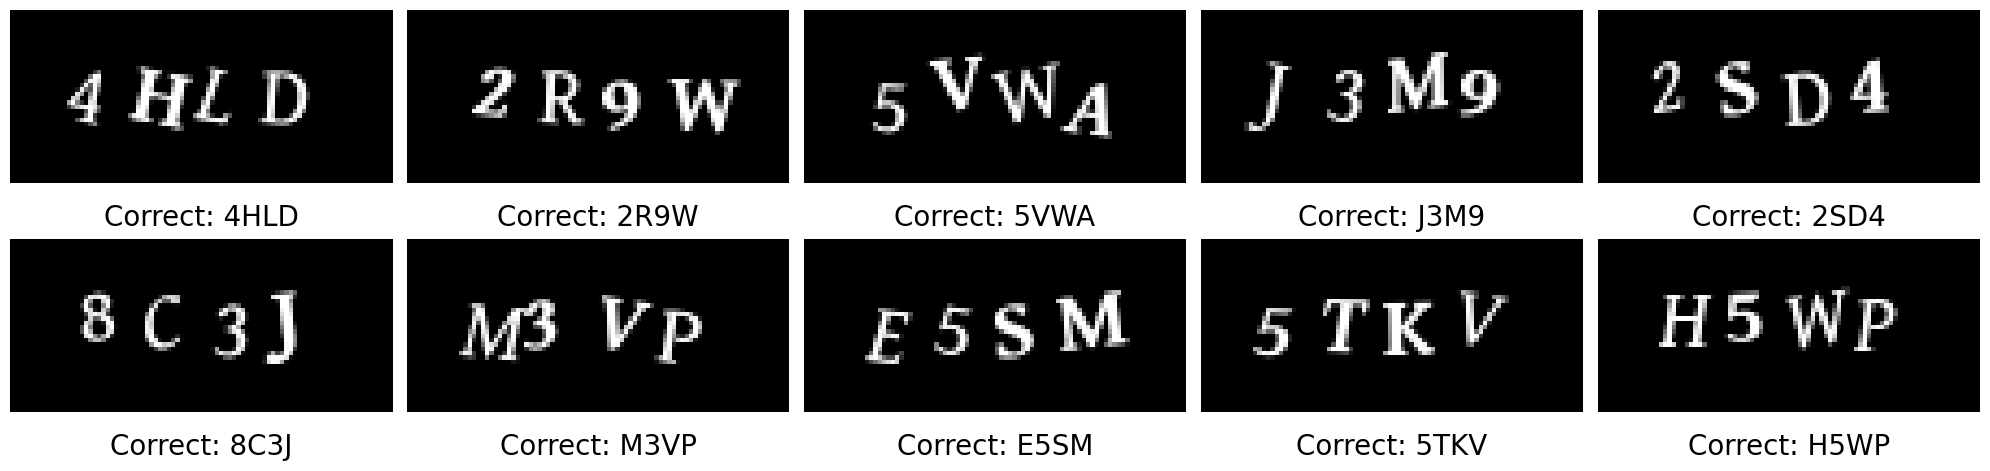

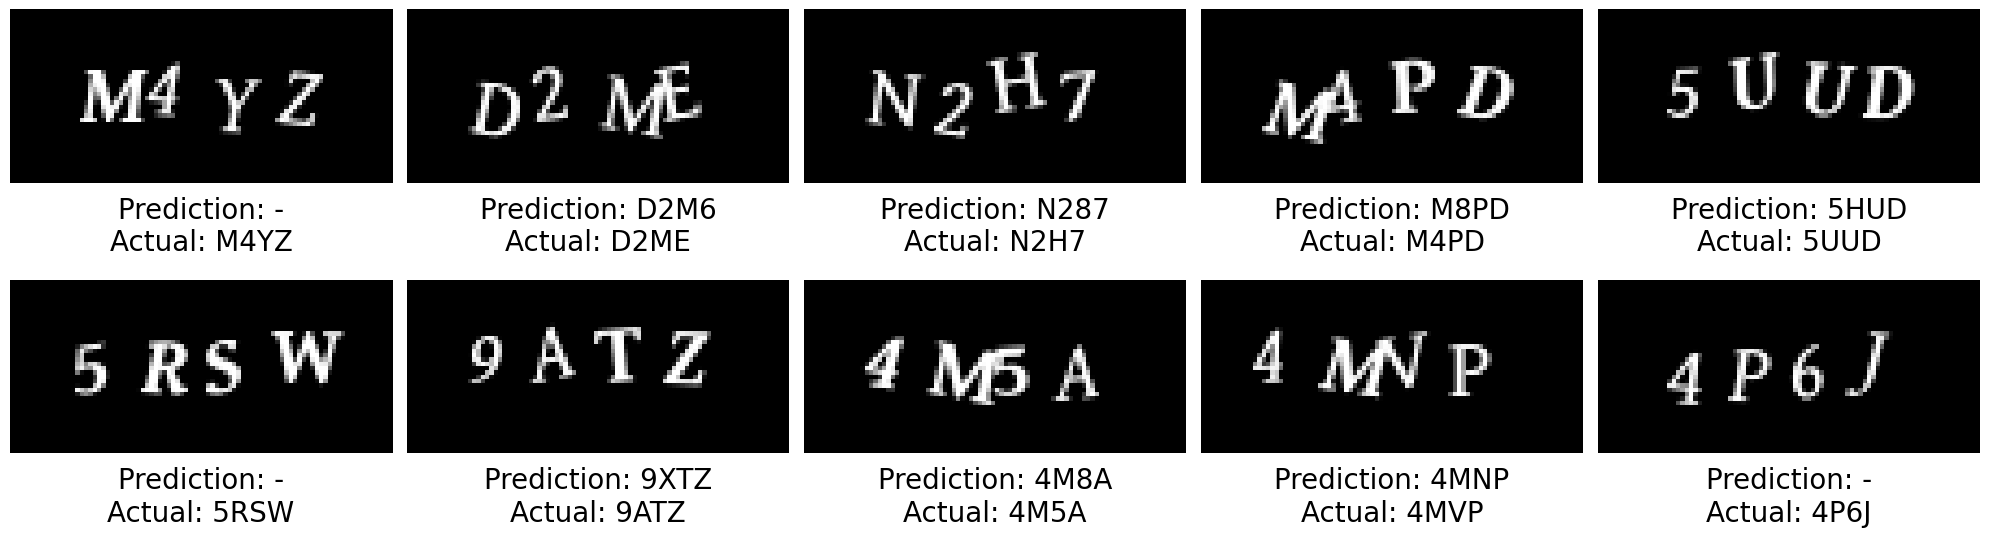

In [12]:
@torch.no_grad()
def predict_chars(model, X: np.ndarray) -> np.ndarray:
    model.eval()
    xb = torch.from_numpy(np.transpose(X, (0, 3, 1, 2))).float().to(device)  # (N,1,20,20)
    logits = model(xb)
    return logits.argmax(dim=1).cpu().numpy().astype(np.int64)

# Load mapping (optional; shows how you'd do it in a fresh session)
with open(LABELS_PATH, "rb") as f:
    mapping = pickle.load(f)
idx_to_char = mapping["idx_to_char"]

DUMMY_CHAR_IMAGES = np.zeros((4, 20, 20, 1), dtype=np.uint8)

extract_failed_indices = []
char_images_test = []

for i, captcha_image in enumerate(captcha_images_test):
    chars = extract_chars(captcha_image)
    if chars is not None:
        char_images_test.extend(chars)
    else:
        extract_failed_indices.append(i)
        char_images_test.extend(list(DUMMY_CHAR_IMAGES))

X_test_chars = np.array([make_feature(img) for img in char_images_test], dtype=np.float32) / 255.0
pred_idx = predict_chars(model, X_test_chars)
pred_chars = [idx_to_char[i] for i in pred_idx]

preds_test = ["".join(group) for group in group_every(pred_chars, 4)]
for i in extract_failed_indices:
    preds_test[i] = "-"

# Accuracy and examples
n_test = len(captcha_texts_test)
n_correct = 0
correct_indices, incorrect_indices = [], []
N_DISPLAY_SAMPLES = 10

for i, (pred_text, actual_text) in enumerate(zip(preds_test, captcha_texts_test)):
    if pred_text == actual_text:
        n_correct += 1
        if len(correct_indices) < N_DISPLAY_SAMPLES:
            correct_indices.append(i)
    else:
        if len(incorrect_indices) < N_DISPLAY_SAMPLES:
            incorrect_indices.append(i)

print("# of test CAPTCHAs:", n_test)
print("# correctly recognized:", n_correct)
print("Accuracy:", n_correct / n_test)

print_images(
    [captcha_images_test[i] for i in correct_indices],
    texts=[f"Correct: {captcha_texts_test[i]}" for i in correct_indices],
    n_rows=2
)

print_images(
    [captcha_images_test[i] for i in incorrect_indices],
    texts=[f"Prediction: {preds_test[i]}\nActual: {captcha_texts_test[i]}" for i in incorrect_indices],
    n_rows=2,
    fig_size=(20, 6),
    text_center=(0.5, -0.25)
)
